In [0]:
from pyspark.sql.functions import col, to_timestamp, to_date, unix_timestamp, current_timestamp

# --- CONFIGURATION ---
CATALOG = "project_fraud_detection"
SOURCE_TABLE = f"{CATALOG}.bronze_layer.bronze_data"
TARGET_TABLE = f"{CATALOG}.silver_layer.cleaned_transactions"

def build_silver_layer():
    """
    Reads ALL Bronze data, applies current transformations, and OVERWRITES Silver.
    Run this as many times as you want while tweaking logic.
    """
    print(f"Loading raw data from: {SOURCE_TABLE}")
    
    # 1. READ (Batch Mode - essential for iterative changes)
    df_bronze = spark.read.table(SOURCE_TABLE)

    # 2. EDITABLE TRANSFORMATION LOGIC
    # Make changes here! (Filter noise, fix types, rename cols)
    df_transformed = df_bronze.select(
        # --- Time Features ---
        to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss").alias("transaction_time"),
        col("unix_time").cast("long"),
        
        # --- Money ---
        col("amt").cast("double").alias("amount"),
        
        # --- Target ---
        col("is_fraud").cast("int"),

        # --- Customer Info (No PII) ---
        col("cc_num").cast("string"),
        col("gender"),
        col("job"),
        # calculating age is better done in Gold, but we prep the DOB here
        to_date(col("dob"), "yyyy-MM-dd").alias("dob"),
        col("city_pop").cast("int").alias("city_population"),

        # --- Location (Crucial for Fraud) ---
        col("category"),
        col("merchant"),
        col("lat").cast("double").alias("cust_lat"),
        col("long").cast("double").alias("cust_long"),
        col("merch_lat").cast("double"),
        col("merch_long").cast("double"),
        col("state"),
        
        # --- Metadata ---
        col("ingestion_time")
    )

    # 3. CLEANING FILTERS (Add/Remove these as you explore)
    df_clean = (df_transformed
        .dropDuplicates() # Remove duplicate rows
        .na.drop(subset=["amount", "is_fraud"]) # Drop if amount/label is missing
        .filter(col("amount") > 0) # Example: Filter out $0 transactions
    )

    # 4. WRITE (Overwrite Mode)
    # This completely replaces the table with your NEW logic
    print(f"Overwriting table: {TARGET_TABLE} with new logic...")
    
    (df_clean.write
        .format("delta")
        .mode("overwrite") # CRITICAL: Replaces old data with new version
        .option("overwriteSchema", "true") # Allows you to change column names/types freely
        .saveAsTable(TARGET_TABLE))
    
    print(f"Success! {TARGET_TABLE} has been updated.")
    
    # 5. Quick Verification (Optional)
    count = spark.table(TARGET_TABLE).count()
    print(f"Total rows in Silver: {count}")

# --- EXECUTE ---
build_silver_layer()

Loading raw data from: project_fraud_detection.bronze_layer.bronze_data
Overwriting table: project_fraud_detection.silver_layer.cleaned_transactions with new logic...
Success! project_fraud_detection.silver_layer.cleaned_transactions has been updated.
Total rows in Silver: 1296675


In [0]:
# --- CONFIGURATION ---
CATALOG = "project_fraud_detection"
TABLE_NAME = f"{CATALOG}.silver_layer.cleaned_transactions"

# --- DISPLAY DATA ---
# Read the table, limit to 10 rows, and display
df_silver = spark.table(TABLE_NAME)
display(df_silver.limit(10))

transaction_time,unix_time,amount,is_fraud,cc_num,gender,job,dob,city_population,category,merchant,cust_lat,cust_long,merch_lat,merch_long,state,ingestion_time
2019-01-02T04:25:32.000Z,1325478332,1.43,0,2512312531485080,M,"Producer, radio",1956-10-08,134056,misc_pos,fraud_Eichmann-Russel,42.5164,-82.9832,43.183689,-82.783158,MI,2026-01-29T09:52:21.125Z
2019-01-04T04:38:16.000Z,1325651896,45.8,0,4900628639996,M,Firefighter,1973-09-22,105549,grocery_pos,fraud_Koepp-Parker,33.9056,-118.0818,33.532513,-117.408724,CA,2026-01-29T09:52:21.125Z
2019-01-05T12:42:03.000Z,1325767323,31.27,0,4536996888716062123,M,Historic buildings inspector/conservation officer,1972-07-18,18408,kids_pets,fraud_Barton LLC,35.9866,-106.0654,35.178173,-106.125677,NM,2026-01-29T09:52:21.125Z
2019-01-05T20:37:01.000Z,1325795821,69.98,0,4191109180926792,F,Farm manager,1992-10-03,4512,entertainment,fraud_Dibbert and Sons,39.6251,-82.7552,40.233833,-82.30797199999999,OH,2026-01-29T09:52:21.125Z
2019-01-06T02:40:25.000Z,1325817625,36.36,0,3560797065840735,F,Film/video editor,1989-12-17,77,grocery_net,fraud_Wuckert-Walter,46.1838,-101.2589,45.641944,-101.88809,ND,2026-01-29T09:52:21.125Z
2019-01-06T13:04:49.000Z,1325855089,14.98,0,4210078554961359092,F,Systems analyst,1965-11-11,1420,home,fraud_Lynch-Wisozk,43.92100000000001,-122.7806,44.551673,-122.453618,OR,2026-01-29T09:52:21.125Z
2019-01-06T23:02:15.000Z,1325890935,27.03,0,180042946491150,M,"Engineer, land",1989-02-28,341043,health_fitness,fraud_Kulas Group,27.7898,-82.7243,27.406681,-83.396493,FL,2026-01-29T09:52:21.125Z
2019-01-07T00:54:43.000Z,1325897683,101.34,0,4067137330196900,F,Politician's assistant,1986-11-12,1186,grocery_pos,"fraud_Casper, Hand and Zulauf",33.9315,-87.6194,34.424001000000004,-87.16992900000001,AL,2026-01-29T09:52:21.125Z
2019-01-07T02:08:37.000Z,1325902117,30.11,0,2720012583106919,M,Volunteer coordinator,1980-08-18,1126,misc_pos,fraud_Flatley Group,43.3526,-102.5411,43.932196000000005,-102.862307,SD,2026-01-29T09:52:21.125Z
2019-01-08T19:17:35.000Z,1326050255,156.68,0,4586810168620942,F,"Sales professional, IT",1997-07-05,2408,health_fitness,fraud_Shields-Wunsch,32.5486,-80.307,32.109178,-79.538563,SC,2026-01-29T09:52:21.125Z


In [0]:
from pyspark.sql.functions import col, count, when, hour, avg, expr
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
CATALOG = "project_fraud_detection"
TABLE_NAME = f"{CATALOG}.silver_layer.cleaned_transactions"

def get_data():
    return spark.table(TABLE_NAME)

# 1. CLASS IMBALANCE CHECK (Crucial for Fraud)
def analyze_class_balance(df, target_col="is_fraud"):
    print(f"--- Analyzing Class Imbalance for '{target_col}' ---")
    total_count = df.count()
    
    distribution = (df.groupBy(target_col)
                    .count()
                    .withColumn("percentage", (col("count") / total_count) * 100))
    
    # Using 'display' gives you an instant Bar Chart in Databricks
    display(distribution)
    return distribution

# 2. NUMERICAL SUMMARY (Statistics)
def analyze_numerical_stats(df, columns):
    print(f"--- Statistics for: {columns} ---")
    # This generates Count, Mean, StdDev, Min, Max for numerical columns
    display(df.select(columns).summary())

# 3. FRAUD PATTERNS BY TIME (Smart Insight)
def analyze_fraud_by_hour(df):
    print("--- Analyzing Fraud Patterns by Hour of Day ---")
    # We extract the Hour from the transaction time
    # Then we calculate the Fraud Rate % for each hour
    hourly_stats = (df.withColumn("hour_of_day", hour("transaction_time"))
                      .groupBy("hour_of_day")
                      .agg(
                          count(when(col("is_fraud") == 1, True)).alias("fraud_cases"),
                          count("*").alias("total_txns")
                      )
                      .withColumn("fraud_rate_percent", (col("fraud_cases") / col("total_txns")) * 100)
                      .orderBy("hour_of_day"))
    
    # Plotting this usually shows spikes at weird hours (e.g., 2 AM)
    display(hourly_stats)

# 4. MISSING VALUES CHECK
def check_nulls(df):
    print("--- Checking for Missing Values ---")
    # Dynamically checks every column for nulls
    null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    display(null_counts)

# --- EXECUTION ENGINE ---
# Load Data
df_silver = get_data()

# Run the Analysis (Comment out ones you don't need right now)
analyze_class_balance(df_silver)
analyze_numerical_stats(df_silver, ["amount", "city_population", "cust_lat"])
analyze_fraud_by_hour(df_silver)
check_nulls(df_silver)

--- Analyzing Class Imbalance for 'is_fraud' ---


is_fraud,count,percentage
1,7506,0.5788651743883394
0,1289169,99.42113482561166


--- Statistics for: ['amount', 'city_population', 'cust_lat'] ---


summary,amount,city_population,cust_lat
count,1296675,1296675,1296675
mean,70.35103545607078,88824.44056297839,38.5376216148914
stddev,160.31603857152766,301956.36068875104,5.075808438803932
min,1.0,23,20.0271
25%,9.65,743,34.6689
50%,47.52,2456,39.3543
75%,83.14,20328,41.9404
max,28948.9,2906700,66.6933


--- Analyzing Fraud Patterns by Hour of Day ---


hour_of_day,fraud_cases,total_txns,fraud_rate_percent
0,635,42502,1.4940473389487554
1,658,42869,1.5349086752665098
2,625,42656,1.4652100525131284
3,609,42769,1.4239285463770488
4,46,41863,0.10988223490910828
5,60,42171,0.1422778686775272
6,40,42300,0.09456264775413711
7,56,42203,0.13269198872118096
8,49,42505,0.1152805552287966
9,47,42185,0.11141400971909447


--- Checking for Missing Values ---


transaction_time,unix_time,amount,is_fraud,cc_num,gender,job,dob,city_population,category,merchant,cust_lat,cust_long,merch_lat,merch_long,state,ingestion_time
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


--- 1. Analyzing Fraud Risk by Category ---


category,fraud_cases,total_txns,fraud_rate_percent
shopping_net,1713,97543,1.7561485703740916
misc_net,915,63287,1.4457945549638946
grocery_pos,1743,123638,1.4097607531665022
shopping_pos,843,116672,0.7225383982446517
gas_transport,618,131659,0.4693944204346076
misc_pos,250,79655,0.31385349318937916
grocery_net,134,45452,0.29481650972454454
travel,116,40507,0.2863702569926186
entertainment,233,94014,0.24783542876592848
personal_care,220,90758,0.2424028735758831


--- 2. Correlation Matrix (Top Numerical Features) ---


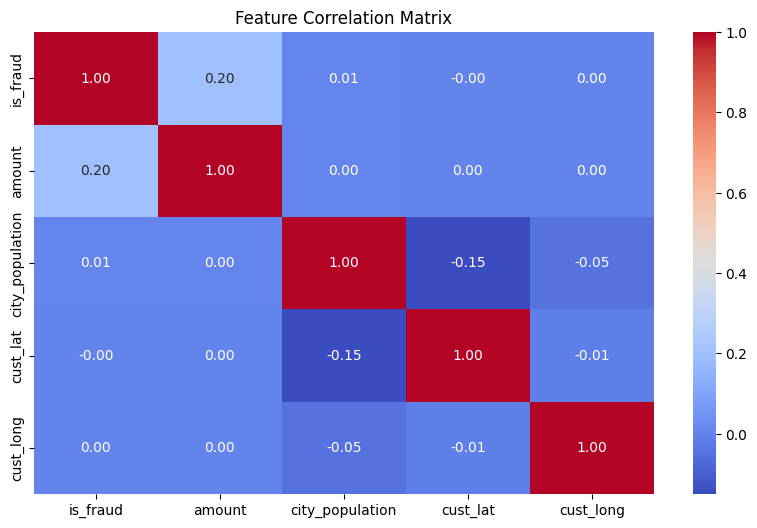

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, count, when, desc

# --- CONFIGURATION ---
CATALOG = "project_fraud_detection"
TABLE_NAME = f"{CATALOG}.silver_layer.cleaned_transactions"

def analyze_fraud_by_category(df):
    print("--- 1. Analyzing Fraud Risk by Category ---")
    # Calculates which categories have the highest % of fraud
    cat_stats = (df.groupBy("category")
                   .agg(
                       count(when(col("is_fraud") == 1, True)).alias("fraud_cases"),
                       count("*").alias("total_txns")
                   )
                   .withColumn("fraud_rate_percent", (col("fraud_cases") / col("total_txns")) * 100)
                   .orderBy(desc("fraud_rate_percent")))
    
    # TIP: When this displays, click the 'Bar Chart' icon in Databricks
    display(cat_stats)

def analyze_correlation(df):
    print("--- 2. Correlation Matrix (Top Numerical Features) ---")
    # We take a sample because correlation on millions of rows is slow and unnecessary
    # We only select numeric columns relevant to fraud
    numeric_cols = ["is_fraud", "amount", "city_population", "cust_lat", "cust_long"]
    
    # Convert to Pandas for plotting (Sampling 10% is usually enough)
    pdf = df.select(numeric_cols).sample(fraction=0.1, seed=42).toPandas()
    
    plt.figure(figsize=(10, 6))
    heatmap = sns.heatmap(pdf.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Matrix")
    plt.show()

# --- EXECUTE ---
df_silver = spark.table(TABLE_NAME)
analyze_fraud_by_category(df_silver)
analyze_correlation(df_silver)

In [0]:
from pyspark.sql.functions import col, count, when, lit
from pyspark.sql.types import DoubleType, IntegerType

# --- CONFIGURATION ---
CATALOG = "project_fraud_detection"
SOURCE_TABLE = f"{CATALOG}.bronze_layer.bronze_data"
TARGET_TABLE = f"{CATALOG}.silver_layer.cleaned_transactions"

def handle_nulls_dynamically(df, threshold=0.10):
    """
    1. If nulls < 10%: DROP rows.
    2. If nulls >= 10%: IMPUTE (Median for numbers, 'Unknown' for text).
    """
    print("--- 1. Dynamic Null Handling ---")
    total_rows = df.count()
    
    # Check null counts
    null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).first().asDict()
    
    cols_to_drop_rows = []
    cols_to_impute_num = []
    cols_to_impute_cat = []

    for col_name, null_count in null_counts.items():
        if null_count > 0:
            null_ratio = null_count / total_rows
            dtype = dict(df.dtypes)[col_name]
            
            if null_ratio < threshold:
                cols_to_drop_rows.append(col_name)
            else:
                if dtype in ['int', 'double', 'float', 'long']:
                    cols_to_impute_num.append(col_name)
                else:
                    cols_to_impute_cat.append(col_name)

    # A. DROP (Pure Strategy)
    if cols_to_drop_rows:
        print(f"-> Dropping rows for low-null columns: {cols_to_drop_rows}")
        df = df.na.drop(subset=cols_to_drop_rows)

    # B. IMPUTE (Save Data Strategy)
    if cols_to_impute_num:
        print(f"-> Imputing high-null numeric columns: {cols_to_impute_num}")
        medians = df.stat.approxQuantile(cols_to_impute_num, [0.5], 0.01)
        median_dict = dict(zip(cols_to_impute_num, medians))
        df = df.na.fill(median_dict)

    if cols_to_impute_cat:
        print(f"-> Imputing high-null category columns: {cols_to_impute_cat}")
        df = df.na.fill("Unknown", subset=cols_to_impute_cat)
        
    return df

def handle_outliers_iqr(df, col_list):
    print("--- 2. Handling Outliers (Capping) ---")
    for column in col_list:
        quantiles = df.stat.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1
        lower_limit = q1 - (1.5 * iqr)
        upper_limit = q3 + (1.5 * iqr)
        
        df = df.withColumn(
            column, 
            when(col(column) > upper_limit, upper_limit)
            .when(col(column) < lower_limit, lower_limit)
            .otherwise(col(column))
        )
    return df

def build_advanced_silver_layer():
    print(f"Loading Raw Data from: {SOURCE_TABLE}")
    df_bronze = spark.read.table(SOURCE_TABLE)
    
    # --- THE FIX: ADDING THE MISSING COLUMNS HERE ---
    df_typed = df_bronze.select(
        # Target & Amount
        col("is_fraud").cast("int"),
        col("amt").cast("double").alias("amount"),
        
        # Time
        col("trans_date_trans_time").cast("timestamp").alias("transaction_time"),
        col("unix_time").cast("long"),  # <--- Was missing
        
        # Customer Details
        col("cc_num").cast("string"),   # <--- Was missing
        col("gender"),                  # <--- Was missing
        col("job"),
        col("dob").cast("date"),
        col("city_pop").cast("int").alias("city_population"),
        
        # Location (Customer)
        col("lat").cast("double").alias("cust_lat"),
        col("long").cast("double").alias("cust_long"),
        col("state"),                   # <--- Was missing
        col("zip"),                     # <--- Was missing
        
        # Location (Merchant)
        col("merchant"),
        col("category"),
        col("merch_lat").cast("double"), # <--- Was missing
        col("merch_long").cast("double"),# <--- Was missing
        
        # Metadata
        col("ingestion_time")
    )

    # 2. RUN DYNAMIC NULL HANDLING
    df_clean = handle_nulls_dynamically(df_typed, threshold=0.10)

    # 3. RUN OUTLIER HANDLING (Money & Population only)
    outlier_cols = ["amount", "city_population"] 
    df_final = handle_outliers_iqr(df_clean, outlier_cols)

    # 4. WRITE
    print(f"Saving to {TARGET_TABLE}...")
    (df_final.write
        .format("delta")
        .mode("overwrite")
        .option("overwriteSchema", "true")
        .saveAsTable(TARGET_TABLE))
    print("Success! All columns included and cleaned.")

# --- EXECUTE ---
build_advanced_silver_layer()

Loading Raw Data from: project_fraud_detection.bronze_layer.bronze_data
--- 1. Dynamic Null Handling ---
--- 2. Handling Outliers (Capping) ---
Saving to project_fraud_detection.silver_layer.cleaned_transactions...
Success! All columns included and cleaned.
